#### Description - Create Figures regarding the Spectrogram Analyses

The primary outputs of this notebook include:

* Figure 3: Representative subject and description of the spectrogram analyses

# Import Libraries

In [1]:
import os
import pandas as pd
import numpy  as np
import os.path as osp
from utils.variables import DATA_DIR, Resources_Dir
from utils.basics import get_available_runs

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import hvplot.pandas
import panel as pn

from scipy.stats import ttest_ind

%matplotlib inline

# Analysis Configuration Variables

In [2]:
region             = 'V4_grp' # Use the Group-Level FV ROI
spectrogram_windur = 60       # Spectrogram Window Duration (In seconds)
Nacq               = 890      # Number of acquisitions

# Generate Time Index for Windowed Results

Having these two indexes will help us plot original data and windowed frequency information in a way that aligns visually and helps with interpretation

In [3]:
# First we generate a regular time index (the one that corresponds to the fMRI TR)
time_index         = pd.timedelta_range(start='0 s', periods=Nacq, freq='s')
print('++ Time Index (first 10 values):')
print(time_index[0:10])

++ Time Index (first 10 values):
TimedeltaIndex(['0 days 00:00:00', '0 days 00:00:01', '0 days 00:00:02',
                '0 days 00:00:03', '0 days 00:00:04', '0 days 00:00:05',
                '0 days 00:00:06', '0 days 00:00:07', '0 days 00:00:08',
                '0 days 00:00:09'],
               dtype='timedelta64[ns]', freq='S')


In [4]:
# Create empty dataframe with index having time_delta in steps of seconds
aux = pd.DataFrame(np.ones(Nacq),index=time_index)
# Simulate rolling windows of spectrogram_windur to gather which index should have data
aux                    = aux.rolling(window=spectrogram_windur, center=True).mean()
aux                    = aux.dropna()
windowed_time_index    = aux.index
print('++ Window Index (first 10 values):')
print(windowed_time_index[0:10])

++ Window Index (first 10 values):
TimedeltaIndex(['0 days 00:00:30', '0 days 00:00:31', '0 days 00:00:32',
                '0 days 00:00:33', '0 days 00:00:34', '0 days 00:00:35',
                '0 days 00:00:36', '0 days 00:00:37', '0 days 00:00:38',
                '0 days 00:00:39'],
               dtype='timedelta64[ns]', freq='S')


*** 
# Figure 3: Explanation of Spectrogram Analyses

This figure is used to explain this part of the analysis on the manuscript. We selected a subject that kept eyes open during the first half of the scan, and then closed eyes later during the second part

In [5]:
# Representative run
sample_run = '283543_rfMRI_REST1_PA'
sbj, run   = sample_run.split('_',1)
# Paths to all necessary outputs for this run
roi_path            = osp.join(DATA_DIR,sbj,run,'{RUN}_mPP.Signal.{REGION}.1D'.format(RUN=run, REGION=region))
spectrogram_path    = osp.join(DATA_DIR,sbj,run,'{RUN}_mPP.Signal.{REGION}.Spectrogram.pkl'.format(RUN=run, REGION=region))
spectrogram_bl_path = osp.join(DATA_DIR,sbj,run,'{RUN}_mPP.Signal.{REGION}.Spectrogram_BandLimited.pkl'.format(RUN=run, REGION=region))
motion_fd_path      = osp.join(DATA_DIR,sbj,run,'{RUN}_Movement_FD.txt'.format(RUN=run))
motion_reg_path     = osp.join(DATA_DIR,sbj,run,'{RUN}_Movement_Regressors.discard10.txt'.format(RUN=run))
# Load all results into memory
sample_spectrogram_df = pd.read_pickle(spectrogram_path)
sample_spectrogram_bl_df = pd.read_pickle(spectrogram_bl_path)
sample_roi_df = pd.DataFrame(np.loadtxt(roi_path),index=time_index,columns=['ROI TS'])

In addition to the original timeseries and its spectral properties, we will also load and inspect eye tracking information and motion

* Load/Plot framewise displacement, translational and rotational motion estimates for this run

In [6]:
mot_fd   = pd.read_csv(motion_fd_path, sep='\t').drop(['Unnamed: 0'], axis=1)
mot_regs = pd.DataFrame(np.loadtxt(motion_reg_path), columns=['x (mm)','y (mm)','z (mm)','rot_x (deg)','rot_y (deg)','rot_z (deg)',
                                                              'x (mm) der','y (mm) der','z (mm) der','rot_x (deg) der','rot_y (deg) der','rot_z (deg) der'])

<AxesSubplot:title={'center':'Rotational Motion'}>

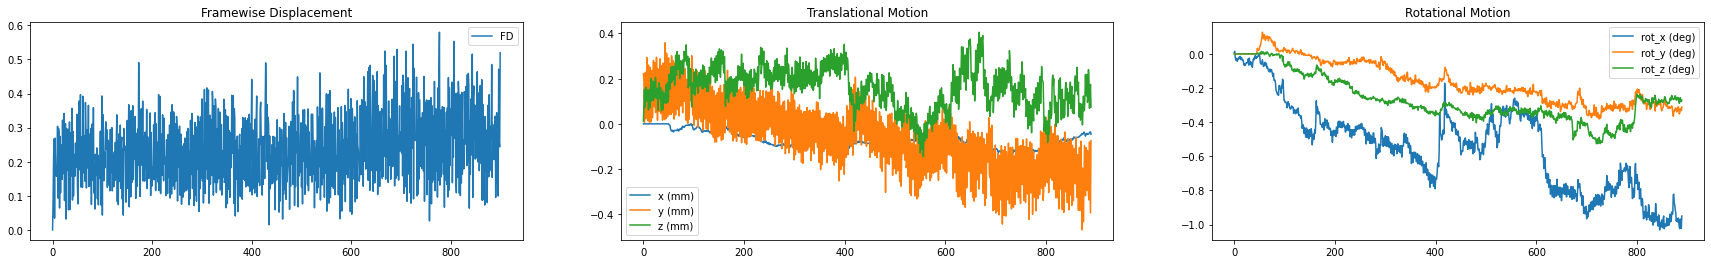

In [7]:
fig,axs = plt.subplots(1,3,figsize=(30,4))
mot_fd.plot(title='Framewise Displacement', ax=axs[0])
mot_regs[['x (mm)','y (mm)','z (mm)']].plot(title='Translational Motion', ax=axs[1])
mot_regs[['rot_x (deg)','rot_y (deg)','rot_z (deg)']].plot(title='Rotational Motion', ax=axs[2])

* Load and Plot periods of eye closure

In [8]:
EC_info = pd.read_pickle('../Resources/EC_Segments_Info.pkl')
EC_info = EC_info[EC_info['Run']==sample_run]
this_run_EC = pd.DataFrame(index=np.arange(890),columns=['ET Trace'])
for r, row in EC_info.iterrows():
    this_run_EC.loc[int(row.Onset):int(row.Offset)] = 1

<AxesSubplot:title={'center':'Eye Closure Periods'}, xlabel='index', ylabel='ET Trace'>

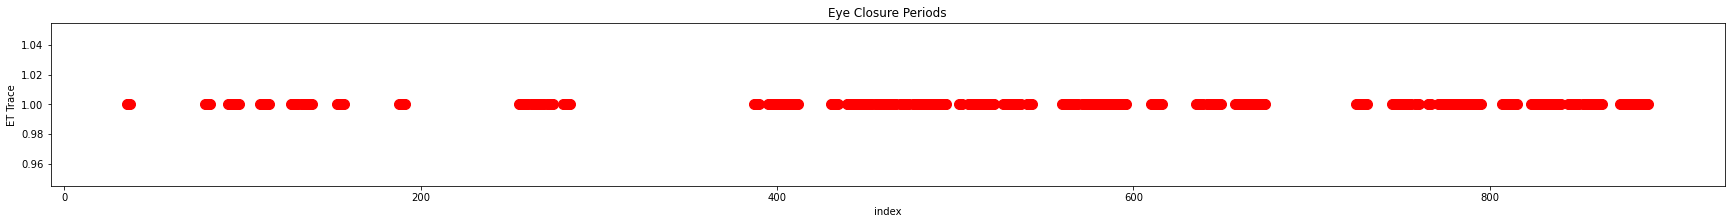

In [9]:
this_run_EC.reset_index().plot(x='index',y='ET Trace', kind='scatter',s=100, title='Eye Closure Periods', c='r', figsize=(30,3))

* Generate actual Figure 3

/data/SFIMJGC_HCP7T/Apps/envs/hcp7t_fv_sleep_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


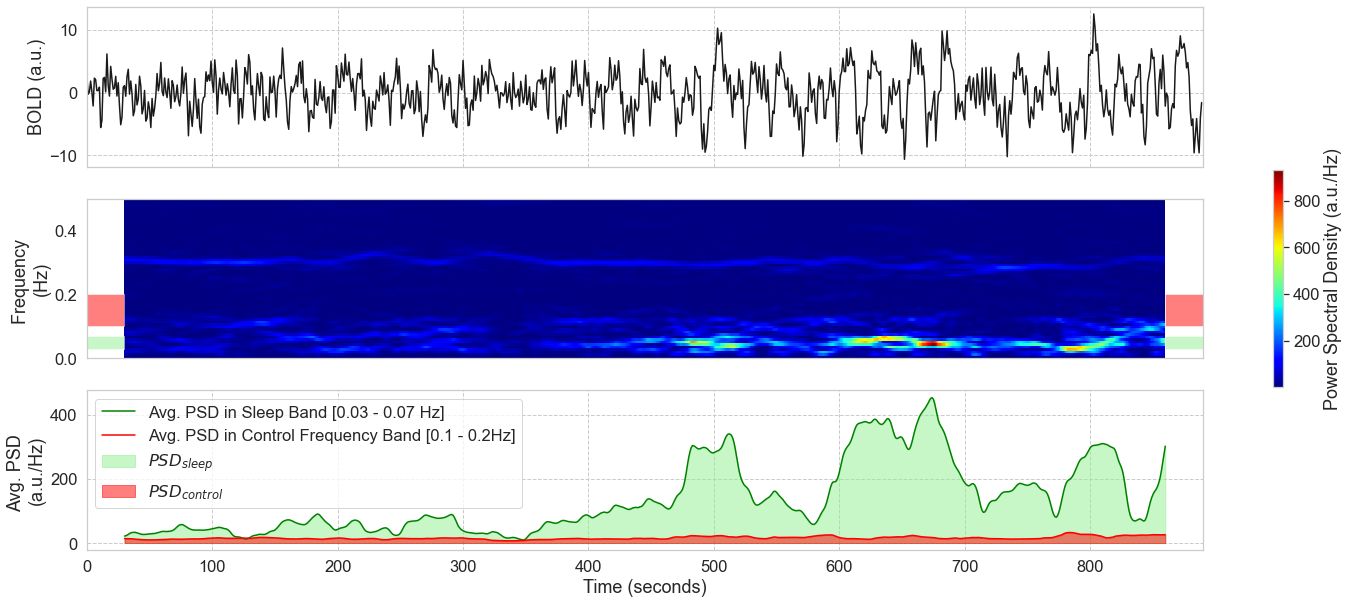

In [10]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid",{"xtick.major.size": 0.1,
    "xtick.minor.size": 0.05,'grid.linestyle': '--'})

fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(25,10))

# Plot BOLD Timeseries
axes[0].plot(time_index.total_seconds(), sample_roi_df, 'k')
axes[0].set_xlim(0,890)
axes[0].set_ylabel('BOLD (a.u.)')
# ADD EYE CLOSURE PERIODS: axes[0].plot(time_index.total_seconds(), 12*this_run_EC['ET Trace'].values, 'ro')
# Plot Spectrogram
im = axes[1].pcolormesh(windowed_time_index.total_seconds(),sample_spectrogram_df.index, sample_spectrogram_df, cmap='jet')
axes[1].set_ylabel('Frequency \n(Hz)')
rect01 = plt.Rectangle((0,   0.03), 30, 0.04, facecolor='lightgreen', alpha=0.5); axes[1].add_patch(rect01)
rect02 = plt.Rectangle((860, 0.03), 30, 0.04, facecolor='lightgreen', alpha=0.5); axes[1].add_patch(rect02)

rect03 = plt.Rectangle((0,   0.1), 30, 0.1, facecolor='red', alpha=0.5); axes[1].add_patch(rect03)
rect04 = plt.Rectangle((860, 0.1), 30, 0.1, facecolor='red', alpha=0.5); axes[1].add_patch(rect04)

axes[1].set_ylim([0,0.5])
fig.colorbar(im, ax=axes[:], shrink=0.4, label='Power Spectral Density (a.u./Hz)')

# Plot Average PSD
PSD_sleep   = axes[2].plot(windowed_time_index.total_seconds(),sample_spectrogram_bl_df['sleep'],c='green')
PSD_control = axes[2].plot(windowed_time_index.total_seconds(),sample_spectrogram_bl_df['non_sleep'],c='red')
axes[2].fill_between(windowed_time_index.total_seconds(),sample_spectrogram_bl_df['sleep'],0, color='lightgreen', alpha=0.5)
axes[2].fill_between(windowed_time_index.total_seconds(),sample_spectrogram_bl_df['non_sleep'],0, color='red', alpha=0.5)
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Avg. PSD \n(a.u./Hz)')
axes[2].legend(['Avg. PSD in Sleep Band [0.03 - 0.07 Hz]','Avg. PSD in Control Frequency Band [0.1 - 0.2Hz]','$PSD_{sleep}$','$PSD_{control}$'])

In [11]:
fig.savefig('./figures/Fig03_PSDexplanation.png')

***
# Figure 6: Evolution of PSD across scan types

### Load list of runs classified as awake and drowsy

In [12]:
%%time
Manuscript_Runs = get_available_runs(when='final', type='all')
Awake_Runs      = get_available_runs(when='final', type='awake')
Drowsy_Runs     = get_available_runs(when='final', type='drowsy')

print('++ INFO: Number of Runs: Total = %d | Awake = %d | Drowsy = %d' % (len(Manuscript_Runs), len(Awake_Runs), len(Drowsy_Runs)))

++ INFO: Number of Runs: Total = 404 | Awake = 210 | Drowsy = 194
CPU times: user 3.63 ms, sys: 1.78 ms, total: 5.42 ms
Wall time: 5.05 ms


***
### Load PSD in Sleep Band

This data is already the result of a windowing operation (computation of the spectrogram). As such, we ensure the index has the correct values corresponding to windowed information

In [13]:
%%time
sleep_psd_DF = pd.DataFrame(index=windowed_time_index, columns=Manuscript_Runs)
ctrol_psd_DF = pd.DataFrame(index=windowed_time_index, columns=Manuscript_Runs)

for sbj_run in Manuscript_Runs:
    sbj,run = sbj_run.split('_',1)
    file    = '{RUN}_mPP.Signal.{REGION}.Spectrogram_BandLimited.pkl'.format(RUN=run, REGION=region)
    path    = osp.join(DATA_DIR,sbj,run,file)
    aux     = pd.read_pickle(path)
    sleep_psd_DF.loc[(windowed_time_index,sbj_run)] = aux['sleep'].values
    ctrol_psd_DF.loc[(windowed_time_index,sbj_run)] = aux['control'].values

sleep_psd_cumsum_DF = sleep_psd_DF.cumsum()
ctrol_psd_cumsum_DF = ctrol_psd_DF.cumsum()

print('++ INFO: Shape of PSD Dataframe [sleep_psd_DF] is %s' % str(sleep_psd_DF.shape))

++ INFO: Shape of PSD Dataframe [sleep_psd_DF] is (831, 404)
CPU times: user 543 ms, sys: 42.7 ms, total: 586 ms
Wall time: 606 ms


***
# Prepare PSD Dataframes for plotting with Seaborn & Compute Cumulative Version of PSD Estimates

In [14]:
# Putting average PSD data into tidy-form with axis in terms of seconds (not delta time)
sleep_psd_DF_copy               = sleep_psd_DF.copy()
sleep_psd_DF_copy.index         = sleep_psd_DF_copy.index.total_seconds()
sleep_psd_cumsum_DF_copy        = sleep_psd_cumsum_DF.copy()
sleep_psd_cumsum_DF_copy.index  = sleep_psd_cumsum_DF_copy.index.total_seconds()
sleep_psd_stacked_DF            = pd.DataFrame(sleep_psd_DF_copy.stack()).reset_index()
sleep_psd_cumsum_stacked_DF     = pd.DataFrame(sleep_psd_cumsum_DF_copy.stack()).reset_index()
# Putting average PSD data into tidy-form with axis in terms of seconds (not delta time)
ctrol_psd_DF_copy               = ctrol_psd_DF.copy()
ctrol_psd_DF_copy.index         = ctrol_psd_DF_copy.index.total_seconds()
ctrol_psd_cumsum_DF_copy        = ctrol_psd_cumsum_DF.copy()
ctrol_psd_cumsum_DF_copy.index  = ctrol_psd_cumsum_DF_copy.index.total_seconds()
ctrol_psd_stacked_DF            = pd.DataFrame(ctrol_psd_DF_copy.stack()).reset_index()
ctrol_psd_cumsum_stacked_DF     = pd.DataFrame(ctrol_psd_cumsum_DF_copy.stack()).reset_index()
# Delete temporary Objects
del sleep_psd_DF_copy, sleep_psd_cumsum_DF_copy, ctrol_psd_DF_copy, ctrol_psd_cumsum_DF_copy

In [15]:
# Rename columns in tidy form dataframes and add extra column with run classification (Drowsy or Awake)
for df in [sleep_psd_stacked_DF, sleep_psd_cumsum_stacked_DF,
           ctrol_psd_stacked_DF, ctrol_psd_cumsum_stacked_DF]:
    df.columns = ['Time [seconds]','Subject','PSD']
    df['Scan Type'] = 'N/A'
    df.loc[(df['Subject'].isin(Awake_Runs),'Scan Type')] = 'Awake'
    df.loc[(df['Subject'].isin(Drowsy_Runs),'Scan Type')] = 'Drowsy'
sleep_psd_stacked_DF['Frequency Band']        = 'Sleep (0.03 - 0.07 Hz)'
sleep_psd_cumsum_stacked_DF['Frequency Band'] = 'Sleep (0.03 - 0.07 Hz)'
ctrol_psd_stacked_DF['Frequency Band']        = 'Control (0.1 - 0.2 Hz)'
ctrol_psd_cumsum_stacked_DF['Frequency Band'] = 'Control (0.1 - 0.2 Hz)'

## Save into a single Dataframe Object for Plotting

In [16]:
df_cum_plot = pd.concat([sleep_psd_cumsum_stacked_DF,ctrol_psd_cumsum_stacked_DF])
df_plot = pd.concat([sleep_psd_stacked_DF,ctrol_psd_stacked_DF])

## Plot the data

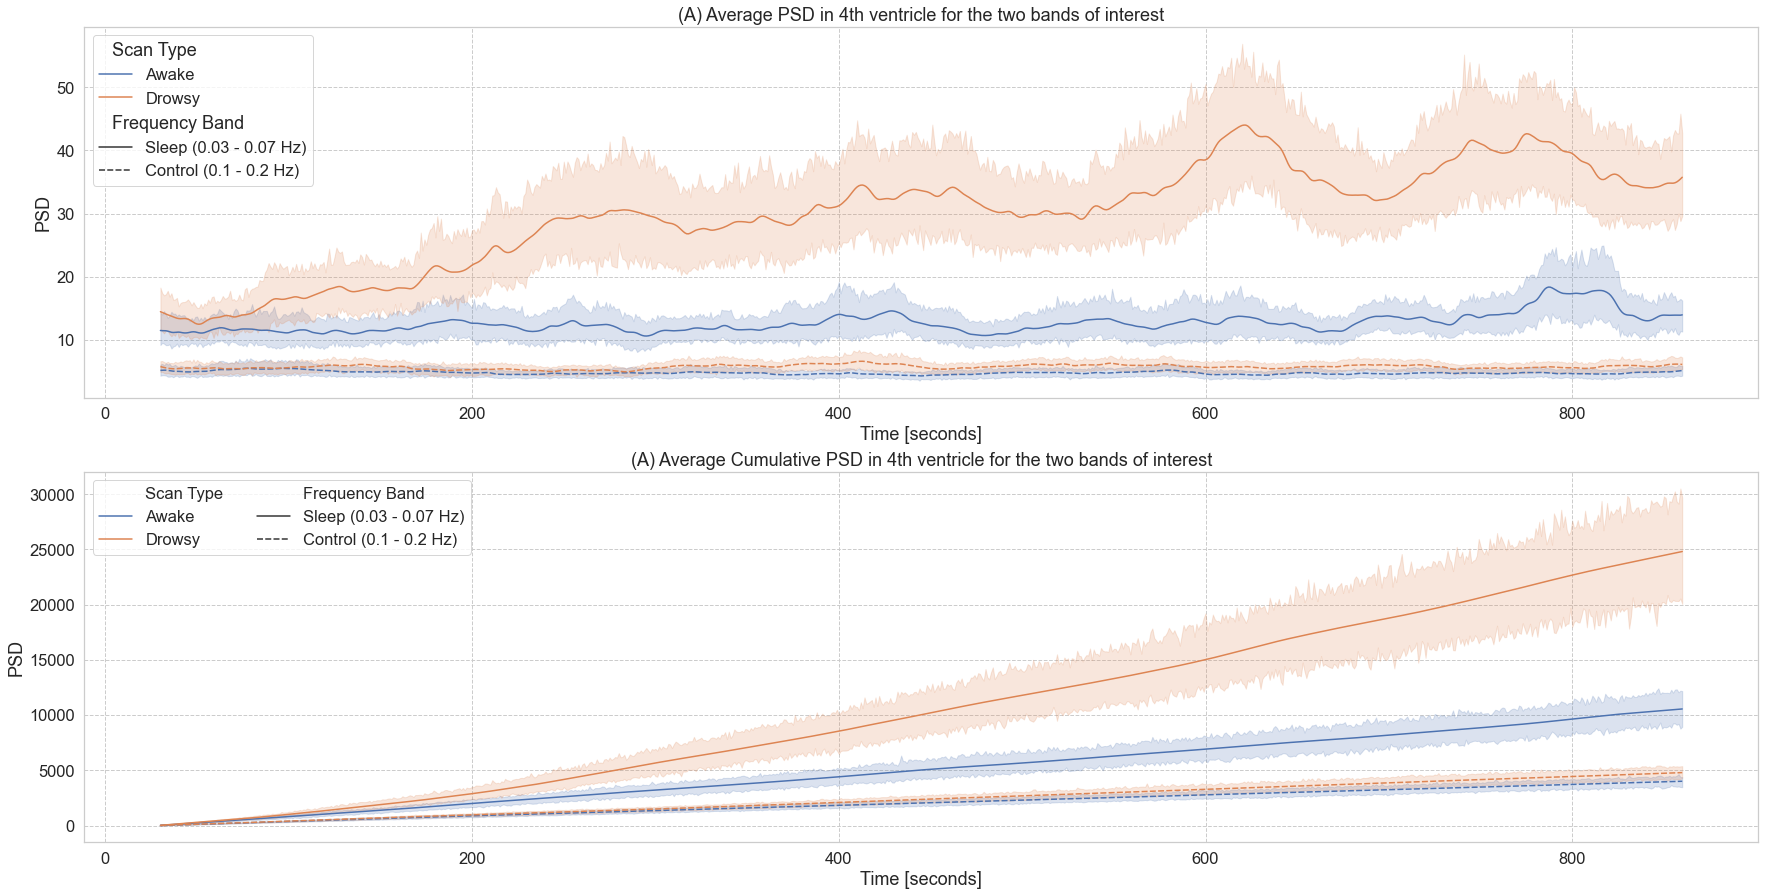

In [17]:
fig, ax = plt.subplots(2,1,figsize=(30,15))
sns.lineplot(data=df_plot, x='Time [seconds]', hue='Scan Type', y='PSD', style='Frequency Band', style_order=['Sleep (0.03 - 0.07 Hz)','Control (0.1 - 0.2 Hz)'], estimator=np.mean, n_boot=100, ax=ax[0])
ax[0].set_title('(A) Average PSD in 4th ventricle for the two bands of interest')
sns.lineplot(data=df_cum_plot, x='Time [seconds]', hue='Scan Type', y='PSD', style='Frequency Band', style_order=['Sleep (0.03 - 0.07 Hz)','Control (0.1 - 0.2 Hz)'], estimator=np.mean, n_boot=100, ax=ax[1])
ax[1].set_title('(A) Average Cumulative PSD in 4th ventricle for the two bands of interest')
ax[1].legend(ncol=2)

> **<u>FINDING:</u>**: As scanning progresses, we see a differentiation in terms of instaneous PSD between subjects who kept their eyes open continously and those who did not. The second group tends to have a higher PSD at longer scanning times. Now becuase periods of eye closure do not necessarily align across subjects, the strength observed here is somehow weak.

> **<u>FINDING:</u>**: As scanning progresses, we see a differentiation in terms of cumulative PSD between subjects who kept their eyes open continously and those who did not. The second group tends to have a higher cumulative PSD at longer scanning times. By looking at cumulative PSD we overcome the limitation mentioned above, and the differentiation across groups becomes more evident

In [18]:
fig.savefig('./figures/Fig06_PSDacrossTime.png')

***
# Scan Ranking based on PSDsleep and GS

## Sort by PSD

Create a figure that shows all scans as colored bars (color by scan type) sorted by PSDsleep rank. This will be one panel in Figure 9

In [19]:
scans_rank                  = pd.DataFrame(columns=['Scan Type'])
scans_rank['PSDsleep Rank'] = sleep_psd_DF.mean().rank(ascending=False).astype(int)
scans_rank['PSDsleep']      = sleep_psd_DF.mean()
scans_rank['Scan Type']     = 'N/A'
scans_rank.loc[(scans_rank.index.isin(Awake_Runs),'Scan Type')] = 'Awake'
scans_rank.loc[(scans_rank.index.isin(Drowsy_Runs),'Scan Type')] = 'Drowsy'

## Sort by StDev of Global Signal

First, we need to load the GS associated with each scan

In [20]:
%%time
GS_df = pd.DataFrame(columns=Manuscript_Runs)
for item in Manuscript_Runs:
    sbj,run  = item.split('_',1)
    aux_path = osp.join(DATA_DIR,sbj,run,'{RUN}_mPP.Signal.FB.1D'.format(RUN=run))
    aux_data = np.loadtxt(aux_path)
    assert aux_data.shape[0] == Nacq, "{file} has incorrect length {length}".format(file=aux_path, length=str(aux_data.shape[0]))
    GS_df[item] = aux_data

CPU times: user 1.12 s, sys: 36.6 ms, total: 1.16 s
Wall time: 1.2 s


Next, we add the new information to the ranking dataframe

In [21]:
scans_rank['GSamplitude']      = GS_df.std()
scans_rank['GSamplitude Rank'] = GS_df.std().rank(ascending=False).astype(int)
scans_rank.head()

Scan Type  PSDsleep Rank   PSDsleep  GSamplitude  \
100610_rfMRI_REST3_PA     Awake            174  13.506049     0.478910   
100610_rfMRI_REST4_AP     Awake            167  14.079479     0.427016   
104416_rfMRI_REST3_PA     Awake            363   2.067901     0.255504   
105923_rfMRI_REST3_PA     Awake            176  13.340720     0.290670   
105923_rfMRI_REST4_AP     Awake             34  53.356402     0.601570   

                       GSamplitude Rank  
100610_rfMRI_REST3_PA                86  
100610_rfMRI_REST4_AP               135  
104416_rfMRI_REST3_PA               343  
105923_rfMRI_REST3_PA               300  
105923_rfMRI_REST4_AP                35

## Generate Figure Panels

In [22]:
fig_ranked_scans = scans_rank.sort_values(by='PSDsleep', ascending=False).hvplot.bar(x='PSDsleep Rank', 
                                                                            y='PSDsleep', 
                                                                            color='Scan Type', 
                                                                            cmap={'Drowsy':'lightblue','Awake':'orange'}, 
                                                                            hover_cols=['index'], size=20, width=800, line_width=0, legend='top_right',
                                                                            title='(A) Scans ranked by PSDsleep of fMRI signal from the 4th Ventricle',
                                                                            fontsize={'minor_ticks':14, 'ticks':14, 'title':16, 'labels':14, 'legend':14}).opts(toolbar=None)
fig_ranked_scans

:Bars   [PSDsleep Rank]   (PSDsleep,Scan Type,index)

Create a second bar plot with the amount of scans of each type in the following rank ranges (0 - 100, 100 - 200, 200 - 300, etc).

In [23]:
df_plot                           = pd.DataFrame(index=['1-100','100-200','200-300','300-404'],columns=['Drowsy','Awake'])
df_plot.loc[('1-100','Awake')]    = scans_rank[(scans_rank['PSDsleep Rank']<=100) & (scans_rank['Scan Type']=='Awake')].shape[0]
df_plot.loc[('1-100','Drowsy')]   = scans_rank[(scans_rank['PSDsleep Rank']<=100) & (scans_rank['Scan Type']=='Drowsy')].shape[0]
df_plot.loc[('100-200','Awake')]  = scans_rank[(scans_rank['PSDsleep Rank']>100) & (scans_rank['PSDsleep Rank']<=200) & (scans_rank['Scan Type']=='Awake')].shape[0]
df_plot.loc[('100-200','Drowsy')] = scans_rank[(scans_rank['PSDsleep Rank']>100) & (scans_rank['PSDsleep Rank']<=200) & (scans_rank['Scan Type']=='Drowsy')].shape[0]
df_plot.loc[('200-300','Awake')]  = scans_rank[(scans_rank['PSDsleep Rank']>200) & (scans_rank['PSDsleep Rank']<=300) & (scans_rank['Scan Type']=='Awake')].shape[0]
df_plot.loc[('200-300','Drowsy')] = scans_rank[(scans_rank['PSDsleep Rank']>200) & (scans_rank['PSDsleep Rank']<=300) & (scans_rank['Scan Type']=='Drowsy')].shape[0]
df_plot.loc[('300-404','Awake')]  = scans_rank[(scans_rank['PSDsleep Rank']>300) & (scans_rank['PSDsleep Rank']<405) & (scans_rank['Scan Type']=='Awake')].shape[0]
df_plot.loc[('300-404','Drowsy')] = scans_rank[(scans_rank['PSDsleep Rank']>300) & (scans_rank['PSDsleep Rank']<405) & (scans_rank['Scan Type']=='Drowsy')].shape[0]

In [24]:
fig_rank_segments_total      = df_plot.hvplot.bar(title='(C) Number of Scans per Rank Segment (Based on PSDsleep)',
                                             width=800,
                                             fontsize={'minor_ticks':14, 'ticks':14, 'title':16,'labels':14},
                                             cmap={'Drowsy':'lightblue','Awake':'orange'}, 
                                             ylabel='Number of Scans', xlabel='Rank Segments').opts(toolbar=None)
fig_rank_segments_total

:Bars   [index,Variable]   (value)

Next, we generate a bar graph with one bar per scan colored by scan type and sorted according to the rank based on GS (Full brain)

In [25]:
fig_gs_ranked_scans = scans_rank.sort_values(by='GSamplitude', ascending=False).hvplot.bar(x='GSamplitude Rank', 
                                                                            y='GSamplitude', 
                                                                            color='Scan Type', 
                                                                            cmap={'Drowsy':'lightblue','Awake':'orange'}, 
                                                                            hover_cols=['index'], size=20, width=800,line_width=0, legend='top_right',
                                                                            title='(B) Scans ranked by GSamplitude',
                                                                            fontsize={'minor_ticks':14, 'ticks':14, 'title':16, 'labels':14, 'legend':14}).opts(toolbar=None)
fig_gs_ranked_scans

:Bars   [GSamplitude Rank]   (GSamplitude,Scan Type,index)

Create a second bar plot with the amount of scans of each type in the following rank ranges (0 - 100, 100 - 200, 200 - 300, etc).

In [26]:
df_plot                           = pd.DataFrame(index=['1-100','100-200','200-300','300-404'],columns=['Drowsy','Awake'])
df_plot.loc[('1-100','Awake')]    = scans_rank[(scans_rank['GSamplitude Rank']<=100) & (scans_rank['Scan Type']=='Awake')].shape[0]
df_plot.loc[('1-100','Drowsy')]   = scans_rank[(scans_rank['GSamplitude Rank']<=100) & (scans_rank['Scan Type']=='Drowsy')].shape[0]
df_plot.loc[('100-200','Awake')]  = scans_rank[(scans_rank['GSamplitude Rank']>100) & (scans_rank['GSamplitude Rank']<=200) & (scans_rank['Scan Type']=='Awake')].shape[0]
df_plot.loc[('100-200','Drowsy')] = scans_rank[(scans_rank['GSamplitude Rank']>100) & (scans_rank['GSamplitude Rank']<=200) & (scans_rank['Scan Type']=='Drowsy')].shape[0]
df_plot.loc[('200-300','Awake')]  = scans_rank[(scans_rank['GSamplitude Rank']>200) & (scans_rank['GSamplitude Rank']<=300) & (scans_rank['Scan Type']=='Awake')].shape[0]
df_plot.loc[('200-300','Drowsy')] = scans_rank[(scans_rank['GSamplitude Rank']>200) & (scans_rank['GSamplitude Rank']<=300) & (scans_rank['Scan Type']=='Drowsy')].shape[0]
df_plot.loc[('300-404','Awake')]  = scans_rank[(scans_rank['GSamplitude Rank']>300) & (scans_rank['GSamplitude Rank']<405) & (scans_rank['Scan Type']=='Awake')].shape[0]
df_plot.loc[('300-404','Drowsy')] = scans_rank[(scans_rank['GSamplitude Rank']>300) & (scans_rank['GSamplitude Rank']<405) & (scans_rank['Scan Type']=='Drowsy')].shape[0]

In [27]:
fig_gs_rank_segments_total = df_plot.hvplot.bar(title='(D) Number of Scans per Rank Segment (Based on GS Amplitude)',
                                             width=800,
                                             fontsize={'minor_ticks':14, 'ticks':14, 'title':16,'labels':14},
                                             cmap={'Drowsy':'lightblue','Awake':'orange'}, 
                                             ylabel='Number of Scans', xlabel='Rank Segments').opts(toolbar=None)
fig_gs_rank_segments_total

:Bars   [index,Variable]   (value)

In [28]:
figure10 = pn.Column(pn.Row(fig_ranked_scans,fig_gs_ranked_scans),
          pn.Row(fig_rank_segments_total,fig_gs_rank_segments_total))

In [29]:
figure10.save('./figures/Fig10_ScanRakings.png')

In [30]:
figure10

Column
    [0] Row
        [0] HoloViews(Bars)
        [1] HoloViews(Bars)
    [1] Row
        [0] HoloViews(Bars)
        [1] HoloViews(Bars)

## Save the list of scans on the top and bottom 100 for both GS and PSD, so we can use those later on N13 to look for network differences

In [31]:
GS_Top100_Runs  = scans_rank[(scans_rank['GSamplitude Rank']<=100)].index.to_list()
GS_Bot100_Runs  = scans_rank[(scans_rank['GSamplitude Rank']>304)].index.to_list()
PSD_Top100_Runs = scans_rank[(scans_rank['PSDsleep Rank']<=100)].index.to_list()
PSD_Bot100_Runs = scans_rank[(scans_rank['PSDsleep Rank']>304)].index.to_list()

for items,filename in zip([GS_Top100_Runs,GS_Bot100_Runs,PSD_Top100_Runs,PSD_Bot100_Runs],
                      ['Run_List_GS_Top100.txt','Run_List_GS_Bot100.txt','Run_List_PSD_Top100.txt','Run_List_PSD_Bot100.txt']):
    path = osp.join(Resources_Dir,filename)
    print('++ Saving scan list: %s' % filename)
    with open(path, 'w') as filehandle:
        for listitem in items:
            filehandle.write('%s\n' % listitem)

++ Saving scan list: Run_List_GS_Top100.txt
++ Saving scan list: Run_List_GS_Bot100.txt
++ Saving scan list: Run_List_PSD_Top100.txt
++ Saving scan list: Run_List_PSD_Bot100.txt


# Statistical Differences in PSDsleep and GS at the Scan Level

In [32]:
ScanLevelMetrics_df = pd.DataFrame(index=GS_df.columns, columns=['PSDsleep','GSamplitude','Scan Type'])
ScanLevelMetrics_df['GSamplitude'] = GS_df.std().values
ScanLevelMetrics_df['PSDsleep']    = sleep_psd_DF.mean()
ScanLevelMetrics_df.loc[(scans_rank.index.isin(Awake_Runs),'Scan Type')] = 'Awake'
ScanLevelMetrics_df.loc[(scans_rank.index.isin(Drowsy_Runs),'Scan Type')] = 'Drowsy'

In [33]:
ScanLevelMetrics_df.head()

PSDsleep  GSamplitude Scan Type
100610_rfMRI_REST3_PA  13.506049     0.478910     Awake
100610_rfMRI_REST4_AP  14.079479     0.427016     Awake
104416_rfMRI_REST3_PA   2.067901     0.255504     Awake
105923_rfMRI_REST3_PA  13.340720     0.290670     Awake
105923_rfMRI_REST4_AP  53.356402     0.601570     Awake

In [34]:
Fig09_panelA = ScanLevelMetrics_df.hvplot.box(y='GSamplitude',by='Scan Type',c='Scan Type', cmap={'Awake':'orange','Drowsy':'lightblue'}, legend=False, title='(A)',fontsize={'title':16,'ylabel':14, 'xlabel':14, 'xticks':14, 'yticks':14}).opts(toolbar=None)
Fig09_panelC = ScanLevelMetrics_df.hvplot.box(y='PSDsleep',by='Scan Type',c='Scan Type', cmap={'Awake':'orange','Drowsy':'lightblue'}, legend=False, title='(C)',fontsize={'title':16,'ylabel':14, 'xlabel':14, 'xticks':14, 'yticks':14}).opts(toolbar=None)

In [35]:
print('++ INFO: Ttest results for GSamplitude')
ttest_ind(ScanLevelMetrics_df['GSamplitude'][ScanLevelMetrics_df['Scan Type']=='Drowsy'],ScanLevelMetrics_df['GSamplitude'][ScanLevelMetrics_df['Scan Type']=='Awake'], alternative='greater')

++ INFO: Ttest results for GSamplitude


Ttest_indResult(statistic=8.342155703278381, pvalue=5.897855267524748e-16)

In [36]:
print('++ INFO: Scan Level Results (PSDsleep)')
print(' +       '+ str(ttest_ind(ScanLevelMetrics_df['PSDsleep'][ScanLevelMetrics_df['Scan Type']=='Drowsy'],ScanLevelMetrics_df['PSDsleep'][ScanLevelMetrics_df['Scan Type']=='Awake'], alternative='greater')))
print('++ INFO: Scan Level Results (GSamplitude)')
print(' +       '+ str(ttest_ind(ScanLevelMetrics_df['GSamplitude'][ScanLevelMetrics_df['Scan Type']=='Drowsy'],ScanLevelMetrics_df['GSamplitude'][ScanLevelMetrics_df['Scan Type']=='Awake'], alternative='greater')))

++ INFO: Scan Level Results (PSDsleep)
 +       Ttest_indResult(statistic=5.663348244902029, pvalue=1.4154238166925026e-08)
++ INFO: Scan Level Results (GSamplitude)
 +       Ttest_indResult(statistic=8.342155703278381, pvalue=5.897855267524748e-16)


# Statistical Differences in PSDsleep and GS at the Segment Level

In [37]:
sleep_psd_DF.index = sleep_psd_DF.index.total_seconds()
EO_segments_info = pd.read_pickle('../Resources/EO_Segments_Info.pkl')
EO_segments_info = EO_segments_info[EO_segments_info['Duration']>=60]
EC_segments_info = pd.read_pickle('../Resources/EC_Segments_Info.pkl')
EC_segments_info = EC_segments_info[EC_segments_info['Duration']>=60]
XX_segments_info = pd.concat([EO_segments_info,EC_segments_info])
XX_segments_info.reset_index(drop=True, inplace=True)

In [38]:
Number_of_Segments = XX_segments_info.shape[0]
SegmentLevelMetrics_df = pd.DataFrame(index=np.arange(Number_of_Segments),columns=['PSDsleep','GSamplitude','Segment Type'])

In [39]:
SegmentType_Label_dict = {'EC':'Eyes Closed','EO':'Eyes Open'}
for r,row in XX_segments_info.iterrows():
    SegmentLevelMetrics_df.loc[r,'GSamplitude']  = GS_df.loc[int(row['Onset']):int(row['Offset']), row['Run']].std()
    SegmentLevelMetrics_df.loc[r,'PSDsleep']     = sleep_psd_DF.loc[(sleep_psd_DF.index >= row['Onset']) & (sleep_psd_DF.index <= row['Offset']),row['Run']].mean()
    SegmentLevelMetrics_df.loc[r,'Segment Type'] = SegmentType_Label_dict[row['Type']]
SegmentLevelMetrics_df = SegmentLevelMetrics_df.infer_objects()

In [40]:
Fig09_panelB = SegmentLevelMetrics_df.hvplot.box(y='GSamplitude',by='Segment Type',c='Segment Type', cmap={'Eyes Open':'orange','Eyes Closed':'lightblue'}, legend=False, title='(B)',fontsize={'title':16,'ylabel':14, 'xlabel':14, 'xticks':14, 'yticks':14}, shared_axes=False).opts(toolbar=None)
Fig09_panelD = SegmentLevelMetrics_df.hvplot.box(y='PSDsleep',   by='Segment Type',c='Segment Type', cmap={'Eyes Open':'orange','Eyes Closed':'lightblue'}, legend=False, title='(D)',fontsize={'title':16,'ylabel':14, 'xlabel':14, 'xticks':14, 'yticks':14}, shared_axes=False).opts(toolbar=None)

In [41]:
print('++ INFO: Segment Level Results (PSDsleep)')
print(' +       '+ str(ttest_ind(SegmentLevelMetrics_df['PSDsleep'][SegmentLevelMetrics_df['Segment Type']=='Eyes Closed'],SegmentLevelMetrics_df['PSDsleep'][SegmentLevelMetrics_df['Segment Type']=='Eyes Open'], alternative='greater')))
print('++ INFO: Segment Level Results (GSamplitude)')
print(' +       '+ str(ttest_ind(SegmentLevelMetrics_df['GSamplitude'][SegmentLevelMetrics_df['Segment Type']=='Eyes Closed'],SegmentLevelMetrics_df['GSamplitude'][SegmentLevelMetrics_df['Segment Type']=='Eyes Open'], alternative='greater')))

++ INFO: Segment Level Results (PSDsleep)
 +       Ttest_indResult(statistic=10.881054442960789, pvalue=1.977743607658272e-26)
++ INFO: Segment Level Results (GSamplitude)
 +       Ttest_indResult(statistic=12.813866696620734, pvalue=3.3702760343841574e-35)


In [44]:
Figure09 = pn.Column(pn.Row(Fig09_panelA,Fig09_panelB),
                     pn.Row(Fig09_panelC,Fig09_panelD))

In [45]:
Figure09

Column
    [0] Row
        [0] HoloViews(BoxWhisker)
        [1] HoloViews(BoxWhisker)
    [1] Row
        [0] HoloViews(BoxWhisker)
        [1] HoloViews(BoxWhisker)

In [47]:
Figure09.save('./figures/Fig09_StatDiff_PSDsleep_GSamplitude.png')